state agents: [[0, 0], False, None]
state agents: [[4, 0], False, None]
Agent 0 sends message: Message send from agent 0
agent0 not hit !!!!!
Agent 1 sends message: Message send from agent 1
agent1 not hit !!!!!
state agents: [[0, 0], False, ['Message send from agent 1']]
state agents: [[4, 0], False, ['Message send from agent 0']]
Agent 0 sends message: Message send from agent 0
agent0 not hit !!!!!
Agent 1 sends message: Message send from agent 1
agent1 not hit !!!!!
state agents: [[0, 0], False, ['Message send from agent 1']]
state agents: [[4, 0], False, ['Message send from agent 0']]
Agent 0 sends message: Message send from agent 0
agent0 not hit !!!!!
Agent 1 sends message: Message send from agent 1
agent1 not hit !!!!!
state agents: [[0, 0], False, ['Message send from agent 1']]
state agents: [[4, 0], False, ['Message send from agent 0']]
Agent 0 sends message: Message send from agent 0
agent0 not hit !!!!!
Agent 1 sends message: Message send from agent 1
agent1 not hit !!!!!
st

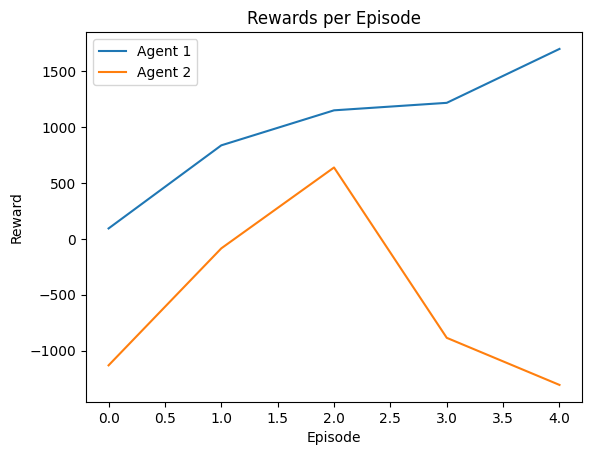

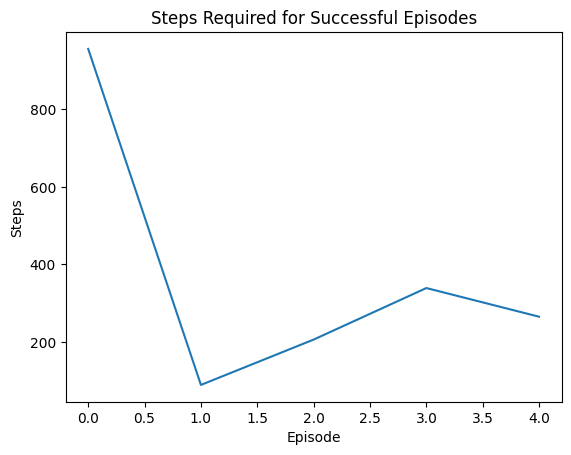

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from environment_ma import Env

class QLearningAgent:
    def __init__(self, env, actions):
        self.env = env
        self.actions = actions
        self.learning_rate = 0.01
        self.discount_factor = 0.9
        self.epsilon = 0.1
        self.q_tables = [defaultdict(lambda: [0.0] * len(actions)) for _ in range(env.num_agents)]
        self.rewards_per_episode = [[] for _ in range(env.num_agents)]  # Initialize rewards list for each agent
        self.successful_episodes = [0] * env.num_agents  # Initialize successful episode count for each agent
        self.total_successful_episodes = 0  # Initialize total successful episode count for all agents

    def learn(self, agent_idx, state, action, reward, next_state, comm_action):
        current_q = self.q_tables[agent_idx][state][action]
        max_next_q = max(self.q_tables[agent_idx][next_state])
        new_q = (current_q + self.learning_rate *
                (reward + self.discount_factor * max_next_q - current_q))
        self.q_tables[agent_idx][state][action] = new_q
        
        # Update q-table with communication action if it's not None
        if comm_action is not None:
            print(f"Agent {agent_idx} sends message: {comm_action}")
            # You can update q-table with communication action here if needed

    def get_action(self, agent_idx, state):
        print(f"state agents: {state}")
        if np.random.rand() < self.epsilon:
            state_action = self.q_tables[agent_idx][state]
            action = self.arg_max(state_action)
        else:
            action = np.random.choice(len(self.actions))
        return action

    def choose_action(self, agent_idx, state):
        physical_action = self.get_action(agent_idx, state)
        if self.env.is_agent_silent:
            communication_action = None
        else:
            communication_action = f"Message send from agent {agent_idx}"
            
        return (physical_action, communication_action)

    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)

    def run_episodes(self, num_episodes):
        success_count = [0] * self.env.num_agents  # Track successful episodes for each agent
        success_steps = []

        for episode in range(num_episodes):
            states = self.env.reset()
            total_reward = [0] * self.env.num_agents  # Initialize total reward for each agent
            step_count = 0
            dones = [False] * self.env.num_agents
            win_states = []
            success_episode = False

            while not (all(dones) and all(win_states)) and step_count <= 10:
                combination_actions = []
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    # print(f"state agents: {state}")
                    physical_action, comm_action = self.choose_action(agent_idx, str(state))
                    combination_actions.append((physical_action, comm_action))

                next_states, rewards, dones = self.env.step(combination_actions)
                
                # print(f"Win States before loop: {win_states}")
                
                win_states = []
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    physical_action = combination_actions[agent_idx][0]
                    comm_action = combination_actions[agent_idx][1]
                    reward = rewards[agent_idx]
                    next_state = next_states[agent_idx]
                    win_state = next_state[1]
                    win_states.append(win_state)    


                    self.learn(agent_idx, str(state), physical_action, reward, str(next_state), comm_action)
                    total_reward[agent_idx] += reward
                    states[agent_idx] = next_state

                    # Check if agent reached target and mark episode as successful
                    if reward == 100:  # Use circle's coordinates for target
                        success_count[agent_idx] += 1
                        print(f"agent{agent_idx} hit !!!!!")
                    else:
                        print(f"agent{agent_idx} not hit !!!!!")

                    # print(f"Reward for agent {agent_idx}: {reward}")
                    # print(f"next state for agent {agent_idx}: {next_state}")
                    # print(f"target: {env.get_circle_grid_position()}")
                    
                
                # print(f"Win States for check: {win_states}")
                step_count += 1

            for agent_idx in range(self.env.num_agents):
                self.rewards_per_episode[agent_idx].append(total_reward[agent_idx])
                print(f"number of success for agent {agent_idx} at episode {episode}: {success_count[agent_idx]/step_count*100}%")

            if all(dones) and all(win_states):
                self.total_successful_episodes += 1
                success_steps.append(step_count)
                success_episode = True

            print(f"Episode: {episode + 1}, Total Steps: {step_count}, Total Rewards: {total_reward}, Status Episode: {success_episode}")
            print("--------------------")

        # Calculate success rate for each agent
        for agent_idx in range(self.env.num_agents):
            agent_success_rate = success_count[agent_idx] / num_episodes * 100
            print(f"Agent {agent_idx + 1} Success Rate: {agent_success_rate}%")

        # Calculate overall success rate for all agents
        overall_success_rate = self.total_successful_episodes / num_episodes * 100
        print(f"Overall Success Rate: {overall_success_rate}%")

        self.plot_rewards_per_episode()
        self.plot_success_steps(success_steps)

    def plot_rewards_per_episode(self):
        num_agents = self.env.num_agents
        for agent_idx in range(num_agents):
            plt.plot(self.rewards_per_episode[agent_idx], label=f'Agent {agent_idx + 1}')

        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_success_steps(success_steps):
        plt.plot(success_steps)
        plt.title('Steps Required for Successful Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
        plt.show()

if __name__ == "__main__":
    num_agents = 2
    is_agent_silent = False  # Set to True or False to enable/disable communication
    env = Env(num_agents=num_agents, is_agent_silent=is_agent_silent)
    actions = list(range(5)) + [(i, 'send') for i in range(5)]
    agent = QLearningAgent(env, actions)

    agent.run_episodes(5)
